In [20]:
import os
from datetime import datetime
import logging
import json

import pandas as pd
import tifffile as tiff

from flame import FLAMEImage
from flame.error import FLAMEImageError

In [21]:
INPUT_DIREC = "/mnt/d/data/raw"
OUTPUT_DIREC = "/mnt/d/data/processed"
DATASET_DIREC = os.path.join(os.getcwd(), "datasets")
DS_TYPE = "denoising"
INPUT_N_FRAMES = 7
OUTPUT_N_FRAMES = 40

In [22]:
logger = logging.getLogger("main")
logging.basicConfig(
    filename=f"{datetime.now().strftime('%Y%m%d-%H%M%S')}_logger.log",
    encoding="utf-8",
    level=logging.DEBUG
)

### Find images to be used in the dataset

In [23]:
IMAGE_INDEX = pd.read_csv(os.path.join(DATASET_DIREC, "raw_image_index.csv"))
IMAGE_INDEX.head()

,id,image
0,0,S268_250409_CAREtraining_PL/CAREtraining_ExViv...
1,1,S268_250409_CAREtraining_PL/CAREtraining_ExViv...
2,2,S268_250409_CAREtraining_PL/CAREtraining_ExViv...
3,3,S268_250409_CAREtraining_PL/CAREtraining_ExViv...
4,4,S268_250409_CAREtraining_PL/CAREtraining_ExViv...


In [24]:
this_ds = {}
for idx, relpath in zip(IMAGE_INDEX['id'], IMAGE_INDEX['image']):
    this_impath = os.path.join(INPUT_DIREC, relpath)
    if os.path.isfile(this_impath):
        logger.info(f"Found image of id {idx} at {this_impath}")
        try:
            this_image = FLAMEImage(this_impath, "tileData.txt")
        except FLAMEImageError as e: # skipping those that could not be initialized for any reasonj
            logger.error(f"Could not initialize image of id {idx} at {this_impath}")
            continue
        if this_image.tileData.framesPerTile != 40:
            logger.warning(f"Skipping image of id {idx} at {this_impath} do to insufficient framesPerTile ({this_image.tileData.framesPerTile} not 40)")
            continue # skipping those without 40 frames
        this_ds[idx] = this_image
    else:
        logger.error(f"Could not find image of id {idx} at {this_impath}")

In [25]:
logger.info(f"Found {len(this_ds)} images for dataset")
print(f"Found {len(this_ds)} images for dataset")
if len(this_ds) < 1:
    logger.error(f"No valid images were found in {INPUT_DIREC}")
    raise Exception(f"No valid images were found in {INPUT_DIREC}")

Found 40 images for dataset


### Documenting Dataset

In [26]:
DS_NAME = f"{datetime.now().strftime('%Y%m%d')}_{len(this_ds)}I_{DS_TYPE}_{INPUT_N_FRAMES}to{OUTPUT_N_FRAMES}F"

In [ ]:
dataset_json = {
    "FLAME_Dataset": {
        "name": DS_NAME,
        "type": DS_TYPE,
        "input": {
            "n_frames": INPUT_N_FRAMES,
            "pixel_mean": None,
            "pixel_std": None,
        },
        "output": {
            "frames": OUTPUT_N_FRAMES,
            "pixel_mean": None,
            "pixel_std": None,
        }
        "image_ids": list(this_ds.keys())
    }
}

### Creating Dataset

In [29]:
DS_OUTPUT_DIREC = os.path.join(OUTPUT_DIREC, DS_NAME)
os.makedirs(DS_OUTPUT_DIREC, exist_ok=True)
logger.info(f"Created dataset output directory at {DS_OUTPUT_DIREC}")

In [45]:
FLAME_Images = []
input_frames_paths = []
output_frames_paths = []
for idx, flame_im in this_ds.items():
    flame_im.openImage() # load image data into memory first

    input_frames_path = os.path.join(DS_OUTPUT_DIREC, f"id{idx}_frames{INPUT_N_FRAMES}.tif")
    input_frames_paths.append(input_frames_path)
    input_frames = flame_im.get_frames(0, INPUT_N_FRAMES)
    logger.info(f"Saving {input_frames_path}...")
    tiff.imwrite(input_frames_path, input_frames)
    
    output_frames_path = os.path.join(DS_OUTPUT_DIREC, f"id{idx}_frames{OUTPUT_N_FRAMES}.tif")
    output_frames_paths.append(output_frames_path)
    output_frames = flame_im.get_frames(0, OUTPUT_N_FRAMES)
    logger.info(f"Saving {output_frames_path}...")
    tiff.imwrite(output_frames_path, output_frames)

    flame_im.closeImage() # close image and force garbage collection for memory management
    FLAME_Images.append(flame_im)

In [ ]:
json_path = os.path.join(DATASET_DIREC, f"{DS_NAME}.json")
json.dump(dataset_json, open(json_path, "w+"))
logger.info(f"Saving dataset config JSON to {json_path}")

### Verification of processing

In [47]:
import numpy as np
import tifffile as tiff
from matplotlib import pyplot as plt
import random

In [62]:
indices = list(range(len(input_frames_paths)))
random.shuffle(indices)
choices = indices[:5]

In [63]:
choices

[3, 27, 8, 29, 22]

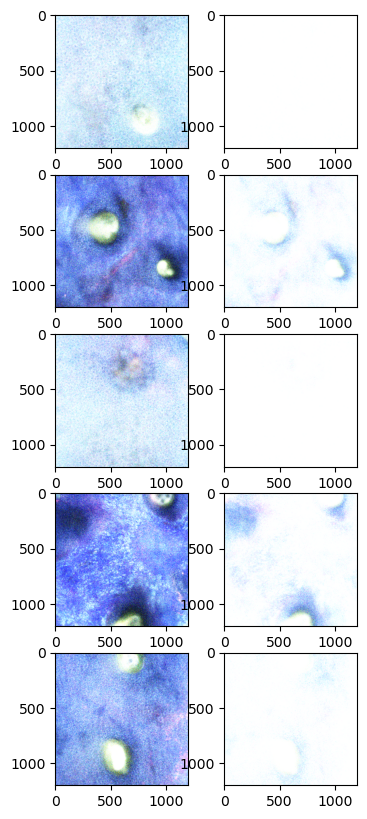

In [74]:
fig = plt.figure(figsize = (4, 2 * len(choices)))
for idx, choice in enumerate(choices):
    left_ax = fig.add_subplot(len(choices), 2, 2 * idx + 1)
    right_ax = fig.add_subplot(len(choices), 2, 2 * idx + 2)
    low_frames = tiff.imread(input_frames_paths[choice]).transpose(1, 2, 0)
    high_frames = tiff.imread(output_frames_paths[choice]).transpose(1, 2, 0)
    left_ax.imshow(low_frames)
    right_ax.imshow(high_frames)
